In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import datetime as dt

from datetime import datetime, timedelta

from datetime import datetime
from matplotlib import pyplot as plt
from scipy.stats import norm, skew, boxcox
#For showing plots directly in the notebook run the command below
%matplotlib inline

from patsy import dmatrices
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 

from sklearn.decomposition import PCA, KernelPCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# For saving multiple plots into a single pdf file
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.pipeline import Pipeline, make_pipeline
# Gets the public holidays for Ireland

In [2]:
df = pd.read_csv('/Users/rebeccadillon/git/dublin-bus-team-5/cleaned_merged_weather_trips.csv', parse_dates=['DAYOFSERVICE'])

In [3]:
df = df[df['DIRECTION']==1]

In [4]:
df.shape[0]

345315

In [23]:
df

,DAYOFSERVICE,HOUR,TRIPID,LINEID,ROUTEID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,rain,temp,is_raining,freezing,PLANNED_TRIPTIME,ACTUAL_TRIPTIME,DIFFERENCE_TRIPTIME,EARLY_LATE,WEEKDAY,MONTH
0,2018-01-02,5,5963422,65,65_73,23878,19800,24834,20409,0.0,5.2,0,0,4078,4425,347,2,1,1
1,2018-01-02,6,5961178,14,14_15,26508,22500,26011,22497,0.5,5.8,1,0,4008,3514,-494,0,1,1
2,2018-01-02,6,5969148,14,14_15,27408,23400,27689,23408,0.5,5.8,1,0,4008,4281,273,2,1,1
3,2018-01-02,6,5963828,41C,41C_78,27293,24000,26565,24021,0.5,5.8,1,0,3293,2544,-749,0,1,1
4,2018-01-02,6,5962897,39,39_20,26881,22920,26636,22878,0.5,5.8,1,0,3961,3758,-203,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345310,2018-12-31,21,8576222,25B,25B_274,80971,78420,81186,78627,0.0,9.9,0,0,2551,2559,8,2,0,12
345311,2018-12-31,22,8580939,130,130_10,80543,79200,81099,79365,0.0,9.9,0,0,1343,1734,391,2,0,12
345312,2018-12-31,22,8587935,27B,27B_23,80640,78900,81401,79293,0.0,9.9,0,0,1740,2108,368,2,0,12
345313,2018-12-31,22,8589536,120,120_12,80376,79200,80529,79202,0.0,9.9,0,0,1176,1327,151,2,0,12


In [5]:
df.drop(columns=['DIRECTION'], inplace=True)


The skew of this distribution is =  0.30242057327678906


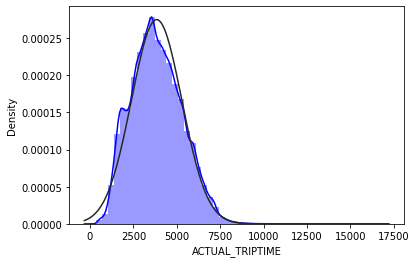

In [6]:
# Analyse the histogram
sns.distplot(df['ACTUAL_TRIPTIME'], fit = norm, kde = True, color = 'blue')
plt.plot()

print('The skew of this distribution is = ', skew(df['ACTUAL_TRIPTIME']))

In [7]:
df.reset_index(inplace= True, drop=True)

In [8]:
categorical_cols = df.select_dtypes(['object']).columns
categorical_cols = categorical_cols.append(df[['HOUR','TRIPID', 'is_raining', 'freezing', 'EARLY_LATE']].columns)
# convert columns in the list to categorical columns
for col in categorical_cols:
    df[col] = df[col].astype('category')
df.dtypes

DAYOFSERVICE           datetime64[ns]
HOUR                         category
TRIPID                       category
LINEID                       category
ROUTEID                      category
PLANNEDTIME_ARR                 int64
PLANNEDTIME_DEP                 int64
ACTUALTIME_ARR                  int64
ACTUALTIME_DEP                  int64
rain                          float64
temp                          float64
is_raining                   category
freezing                     category
PLANNED_TRIPTIME                int64
ACTUAL_TRIPTIME                 int64
DIFFERENCE_TRIPTIME             int64
EARLY_LATE                   category
WEEKDAY                         int64
MONTH                           int64
dtype: object

In [9]:
continuous_cols = df.select_dtypes(['int64','float64','datetime64[ns]']).columns


In [24]:
routes = ['1',
 '102',
 '104',
 '11',
 '111',
 '114',
 '116',
 '118',
 '120',
 '122',
 '123',
 '13',
 '130',
 '14',
 '140',
 '142',
 '145']

In [25]:
# Arranging the final parameters in a stops dictionary
DF_Dictionary = {}

for route in routes:
    DF_Dictionary[route] =  df[df['LINEID'] == route]
                                           
DF_Dictionary

{'1':        DAYOFSERVICE HOUR   TRIPID LINEID ROUTEID  PLANNEDTIME_ARR  \
 232      2018-01-02    9  5971203      1    1_37            35542   
 331      2018-01-02   11  5971205      1    1_37            45037   
 546      2018-01-02   16  5965225      1    1_37            61001   
 659      2018-01-02   17  5971209      1    1_37            64474   
 660      2018-01-02   17  5963396      1    1_37            66874   
 ...             ...  ...      ...    ...     ...              ...   
 345147   2018-12-31   20  8584459      1    1_37            76384   
 345204   2018-12-31   20  8584548      1    1_37            75628   
 345205   2018-12-31   20  8585118      1    1_37            74428   
 345249   2018-12-31   21  8584628      1    1_37            78784   
 345250   2018-12-31   21  8587045      1    1_37            77584   
 
         PLANNEDTIME_DEP  ACTUALTIME_ARR  ACTUALTIME_DEP  rain  temp  \
 232               32400           34946           32424   0.5   8.9   
 331     

In [37]:
# generating the test train dictionary for target feature JOURNEYTIME
X_trainDict = {}
y_trainDict = {}
X_testDict = {}
y_testDict = {}

remove = []

for route in routes:
        
    y = DF_Dictionary[route]['ACTUAL_TRIPTIME']
    X = DF_Dictionary[route].drop(['ACTUAL_TRIPTIME', 'LINEID','DAYOFSERVICE', 'ROUTEID'], 1)
    
    
    if X.shape[0] < 3:
        print(f'{route} too small')
        remove.append(route)
        continue
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)
    
    X_trainDict[route] = X_train
    X_testDict[route] = X_test
    y_trainDict[route] = y_train
    y_testDict[route] = y_test
    
    
    # need to reset the index to allow concatatenation with predicted values otherwise not joining on same index...
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    
    #print(X_train)
    
for i in remove:
    routes.remove(i)

In [38]:
# Modelling for each stop pair
modelDict = {}


for route in routes:
    #print(f'Modelling route number {route}.')
  
    X_train = X_trainDict[route]        
    X_test = X_testDict[route]
    y_train = y_trainDict[route]
    y_test = y_testDict[route]
    
    model =  LinearRegression()
    modelDict[route] = model.fit(X_train, y_train)

    endStop = int(df[df['LINEID']==route]['LINEID'].mode())
    
    filename = f'MODEL_{route}.sav'
    pickle.dump(modelDict[route], open(filename,'wb'))
    

In [39]:
#This function is used repeatedly to compute all metrics
def printStopMetrics(testActualVal, predictions):
    #classification evaluation measures
    print('\n==============================================================================')
    print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
    print("MAPE: ", metrics.mean_absolute_percentage_error(testActualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(testActualVal, predictions))
    print('\n==============================================================================\n')

In [41]:
for route in routes:
    print(f'Modelling stop number {route}.')
  
    X_train = X_trainDict[route]
    y_train = y_trainDict[route]

    train_predictions = modelDict[route].predict(X_train)
    print("Actual vs predicted on training:\n", pd.concat([y_train, pd.DataFrame(train_predictions, columns=['Predicted'], index=y_train.index)], axis=1))
    printStopMetrics(y_train, train_predictions)
    
    # Write Information to File
    with open(f'{route}_Regression.csv','a') as fh:
        fh.write('\n\n=========================================================='+\
                f'\nMetrics for stop model number {route}:'
                f'\nMAE:{metrics.mean_absolute_error(y_train, train_predictions)}'+\
                f'\nMAPE:{metrics.mean_absolute_percentage_error(y_train, train_predictions)}'
                f'\nRMSE:{metrics.mean_squared_error(y_train, train_predictions)**0.5}'+\
                f'\nR2:{metrics.r2_score(y_train, train_predictions)}') 

Modelling stop number 1.
Actual vs predicted on training:
       ACTUAL_TRIPTIME  Predicted
0                3073     3073.0
1                2959     2959.0
2                2729     2729.0
3                3236     3236.0
4                2969     2969.0
...               ...        ...
4020             3032     3032.0
4021             3491     3491.0
4022             2708     2708.0
4023             2595     2595.0
4024             3591     3591.0

[4025 rows x 2 columns]

MAE:  8.496759359591773e-11
MAPE:  3.3893734966209734e-14
RMSE:  9.877832895062862e-11
R2:  1.0


Modelling stop number 102.
Actual vs predicted on training:
       ACTUAL_TRIPTIME  Predicted
0                3056     3056.0
1                4123     4123.0
2                3790     3790.0
3                3338     3338.0
4                4099     4099.0
...               ...        ...
2116             4169     4169.0
2117             2266     2266.0
2118             3597     3597.0
2119             3490     3490